<a id='top'></a>
<h1>Table of Contents</h1>
<ol>
    <li><a href="#section1">Project Introduction</a></li>
    <li><a href="#section2">Section 2</a></li>
    <li><a href="#section3">Section 3</a></li>
</ol>

<a id='section1'></a>
# 1. Project Introduction

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

#CONFIGS
pd.options.display.max_columns = 100

# Data accessment and cleaning
A data dictionary of the listings.csv dataset can be found [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596).

In [2]:
# import listings files
listings_df_202303 = pd.read_csv("input-data\\202303-listings.csv")
listings_df_202212 = pd.read_csv("input-data\\202212-listings.csv")
listings_df_202209 = pd.read_csv("input-data\\202209-listings.csv")
listings_df_202206 = pd.read_csv("input-data\\202206-listings.csv")

listings_df_202303["file_name"] = "202303-listings.csv"
listings_df_202212["file_name"] = "202212-listings.csv"
listings_df_202209["file_name"] = "202209-listings.csv"
listings_df_202206["file_name"] = "202206-listings.csv"

listings_df_ls = [listings_df_202303, listings_df_202212, listings_df_202209, listings_df_202206]

## First cleaning
### Columns removal
In this step I will remove columns which do not include relevant information for this project. I considered the following types of columns as not relevant:
1. It contains meta information about the listing like URL or description (this one could be important if NLP analysis was in scope);
2. Technical columns like scrape ID or date;
3. Personal data like name of the host;
4. Host-related data, since it is not relevant for the purpose of this analysis;
5. Columns with a high number of nulls;
6. Other columns which I considered too specific for the purpose of this analysis.

In [3]:
listings_df_ls[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12410 entries, 0 to 12409
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            12410 non-null  int64  
 1   listing_url                                   12410 non-null  object 
 2   scrape_id                                     12410 non-null  int64  
 3   last_scraped                                  12410 non-null  object 
 4   source                                        12410 non-null  object 
 5   name                                          12410 non-null  object 
 6   description                                   12405 non-null  object 
 7   neighborhood_overview                         7608 non-null   object 
 8   picture_url                                   12410 non-null  object 
 9   host_id                                       12410 non-null 

In [4]:
def drop_cols(df, col_list):
    """
    Description
    -----------
    This function drops a specified list of columns for a given pandas DataFrame. The columns in the list must do not necessarily need to exist in the DataFrame.  
    
    Arguments
    ---------
    df: pandas DataFrame
        a pandas DataFrame from which the columns should be removed.

    col_list: list
        a list of columns to be removed from the pandas DataFrame.

    Returns
    -------
    df: pandas DataFrame
        a pandas DataFrame with the columns removed which were found in the list.
    """   
    
    for col in col_list:
        if col in df.columns:
            df = df.drop(col, axis=1)
            
    return df

In [5]:
drop_col_ls = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
               'description', 'neighborhood_overview', 'picture_url', 'host_url',
               'host_name','host_since', 'host_location', 'host_about','host_response_time', 
               'host_response_rate', 'host_acceptance_rate','host_thumbnail_url', 'host_picture_url',
               'host_neighbourhood', 'host_total_listings_count','host_verifications','host_has_profile_pic', 
               'host_listings_count', 'host_identity_verified', 'neighbourhood','bathrooms','minimum_nights',
               'maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',
               'maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated',
               'has_availability','availability_30','availability_60','availability_365','number_of_reviews_ltm',
               'number_of_reviews_l30d','first_review','last_review','review_scores_accuracy',
               'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
               'review_scores_location','review_scores_rating','instant_bookable','license',
               'calculated_host_listings_count','calculated_host_listings_count_entire_homes', 
               'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
               'reviews_per_month']

# remove the columns for each DataFrame in the list
for i in range(0, len(listings_df_ls)):
    listings_df_ls[i] = drop_cols(listings_df_ls[i], drop_col_ls)

#### <a href="#top">Back to top</a>
<a id='section1'></a>

### Dealing with missing data

In [6]:
# Print the number of nulls per column for each DataFrame
for i in range(0, len(listings_df_ls)):
    print(f"""TABLE NAME: {listings_df_ls[i]["file_name"].unique()[0]}""")
    print("------------------------------------------------------------\n")
    print(listings_df_ls[i].isnull().sum())
    print("\n------------------------------------------------------------\n")

TABLE NAME: 202303-listings.csv
------------------------------------------------------------

id                                 0
host_id                            0
host_is_superhost                  0
neighbourhood_cleansed             0
neighbourhood_group_cleansed       0
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms_text                    14
bedrooms                        1294
beds                              87
amenities                          0
price                              0
availability_90                    0
calendar_last_scraped              0
number_of_reviews                  0
review_scores_value             1622
file_name                          0
dtype: int64

------------------------------------------------------------

TABLE NAME: 202212-listings.csv
----------------------------------------------------------

It is possible to see that list of columns with missing data is similar for each DataFrame, so the chosen approaches will be used for all of the DataFrames.

For the purpose of the exploratory data analysis I decided to __address__ the following columns:
- bedrooms
- beds

For the purpose of the exploratory data analysis I decided to __ignore__ the following columns:
- host_is_superhost
- bathrooms_text
- review_scores_value

#### Procedure
Since the column _accomodates_ is always filled I simply used the __mode__ of the available data within the column to be treated while accounting for each corresponding value inside the column _accomodates_.

In [7]:
def fill_data_with_mode(df, ref_col, col_list):
    """
    Description
    -----------
    This function fills in missing data for a given list of columns in a pandas DataFrame based on the mode available in the missing column for a particular group of values available on a specified reference column.
    
    Arguments
    ---------
    df: pandas DataFrame
        a pandas DataFrame in which the missing data will be filled.
        
    ref_col: string
        the name of the reference column, from which the value group will be used to calculate the mode.
        
    col_list: list
        a list of columns with missing data.

    Returns
    -------
    df: pandas DataFrame
        a pandas DataFrame with the filled missing data.
    """   
    
    for col in col_list:
        mode_per_group = df.groupby(ref_col)[col].transform(lambda x: x.mode()[0])
        df[col] = df[col].fillna(mode_per_group)
    
    return df

In [8]:
ref_col = "accommodates"
missing_col_ls = ["bedrooms","beds"]

# fill in the missing data
for i in range(0, len(listings_df_ls)):
    listings_df_ls[i] = fill_data_with_mode(listings_df_ls[i],ref_col,missing_col_ls)

# quality check for missing data
print(f"""Missing data in bedrooms: {listings_df_ls[0]["bedrooms"].isnull().sum()}""")
print(f"""Missing data in bedrooms: {listings_df_ls[0]["beds"].isnull().sum()}""")    

Missing data in bedrooms: 0
Missing data in bedrooms: 0


#### <a href="#top">Back to top</a>

### Data quality check
Since I am going to focus the analysis of ocupancy rates baed on the column _availability_90_, I wanted to make a quick quality check to see if the data matches with the day-by-day availabiliy data in the calendar.csv for a speficic listing ID. I simply chose the first ID available: 840535633089695952.

In [9]:
#print 90-days' availability data in the 202303-listings.csv
listings_df_202303[listings_df_202303["id"] == 840535633089695952][["id","availability_90"]].head()

,id,availability_90
0,840535633089695952,72


In [10]:
#import calendar data for 2023
calendar_df_202303 = pd.read_csv("input-data\\202303-calendar.csv")
calendar_df_202303['date'] = pd.to_datetime(calendar_df_202303['date'])

#filter the date for the listing id and the next 90 days
start_date = min(calendar_df_202303['date']) #date of the extract
end_date = start_date + pd.DateOffset(days=90) #90 days after

id_filter = calendar_df_202303["listing_id"] == 840535633089695952
date_filter = (calendar_df_202303["date"] >= start_date) & (calendar_df_202303["date"] < end_date)
combined_filter = id_filter & date_filter

filtered_calendar_df_202303 = calendar_df_202303[combined_filter]

nr_available_days = len(filtered_calendar_df_202303[filtered_calendar_df_202303["available"] == "t"])
print(f"""The listing id {str(filtered_calendar_df_202303["listing_id"].unique()[0])} was {nr_available_days} days available between {str(start_date)[:10]} and {str(end_date)[:10]}.""")

The listing id 840535633089695952 was 72 days available between 2023-03-17 and 2023-06-15.


#### <a href="#top">Back to top</a>

### Deal with categorical columns
In this section the were checked for inconsistencies and when necessary converted into a different data type in order to facilitate analysis.

In [11]:
listings_df_ls[0].tail(2)

,id,host_id,host_is_superhost,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,availability_90,calendar_last_scraped,number_of_reviews,review_scores_value,file_name
12408,2643760,4287899,t,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",PORTO,41.14407,-8.61246,Entire rental unit,Entire home/apt,2,1 bath,1.0,1.0,"[""Patio or balcony"", ""Wine glasses"", ""Bidet"", ...",$70.00,34,2023-03-18,231,4.76,202303-listings.csv
12409,24408708,184264583,f,Aguçadoura e Navais,PÓVOA DE VARZIM,41.42545,-8.77694,Entire home,Entire home/apt,10,2 baths,3.0,5.0,"[""Crib"", ""Wine glasses"", ""Bidet"", ""Room-darken...",$95.00,53,2023-03-18,27,4.44,202303-listings.csv


__neighbourhood_cleansed:__

In [12]:
print(listings_df_ls[0]['neighbourhood_cleansed'].unique())

['Paranhos' 'Lordelo do Ouro e Massarelos' 'Bonfim'
 'Matosinhos e Leça da Palmeira' 'Ramalde' 'Canidelo' 'Arcozelo'
 'Mafamude e Vilar do Paraíso' 'Aldoar, Foz do Douro e Nevogilde'
 'Santa Marinha e São Pedro da Afurada'
 'São Mamede de Infesta e Senhora da Hora' 'Árvore'
 'St. Tirso, Couto (S. Cristina e S. Miguel) e Burgães' 'Valongo'
 'Baguim do Monte (Rio Tinto)' 'Recarei'
 'Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, Vitória' 'Arouca e Burgo'
 'Várzea' 'Santa Maria da Feira, Travanca, Sanfins e Espargo' 'São Roque'
 'Gondomar (São Cosme), Valbom e Jovim' 'Santa Maria de Lamas'
 'AVer-o-Mar, Amorim e Terroso' 'Canelas e Espiunca' 'Aguçadoura e Navais'
 'Balazar' 'Vila do Conde'
 'O. Azeméis, Riba-Ul, Ul, Macinhata da Seixa, Madail'
 'Custóias, Leça do Balio e Guifões' 'Gulpilhares e Valadares'
 'Póvoa de Varzim, Beiriz e Argivai' 'São Félix da Marinha' 'Rio Tinto'
 'Vila Chã, Codal e Vila Cova de Perrinho' 'Espinho' 'Oliveira do Douro'
 'Campanhã' 'Milheirós de Poiares' 'Touguin

Nothing unusual with the column _neighbourhood_cleansed_.

__neighbourhood_group_cleansed:__

In [13]:
print(listings_df_ls[0]['neighbourhood_group_cleansed'].unique())

['PORTO' 'MATOSINHOS' 'VILA NOVA DE GAIA' 'VILA DO CONDE' 'SANTO TIRSO'
 'VALONGO' 'GONDOMAR' 'PAREDES' 'AROUCA' 'SANTA MARIA DA FEIRA'
 'OLIVEIRA DE AZEMÉIS' 'PÓVOA DE VARZIM' 'VALE DE CAMBRA' 'ESPINHO' 'MAIA'
 'SÃO JOÃO DA MADEIRA' 'TROFA']


Nothing unusual with the column _neighbourhood_group_cleansed_.

__property_type:__

In [14]:
print(listings_df_ls[0]['property_type'].unique())

['Shared room in rental unit' 'Shared room in home'
 'Private room in rental unit' 'Entire rental unit' 'Entire loft'
 'Entire condo' 'Entire home' 'Private room in townhouse' 'Entire cabin'
 'Treehouse' 'Entire vacation home' 'Entire villa' 'Private room in home'
 'Private room' 'Private room in guesthouse' 'Entire townhouse'
 'Room in hotel' 'Camper/RV' 'Entire place' 'Entire serviced apartment'
 'Room in boutique hotel' 'Room in aparthotel' 'Entire cottage'
 'Private room in villa' 'Entire bungalow' 'Private room in condo'
 'Tiny home' 'Shared room in bed and breakfast'
 'Private room in bed and breakfast' 'Private room in casa particular'
 'Private room in earthen home' 'Casa particular' 'Private room in hostel'
 'Shared room in hostel' 'Entire guesthouse' 'Private room in boat' 'Boat'
 'Earthen home' 'Room in serviced apartment' 'Room in hostel'
 'Private room in guest suite' 'Farm stay' 'Private room in nature lodge'
 'Entire guest suite' 'Private room in loft' 'Private room in b

Nothing unusual with the column _property_type_.

__bathrooms_text:__

In [15]:
print(listings_df_ls[0]['bathrooms_text'].unique())

['1.5 shared baths' '2 shared baths' '1 private bath' '3 shared baths'
 '1 bath' '2 baths' '1 shared bath' '5 baths' '3 baths' '6 baths'
 '1.5 baths' '7 baths' '4 baths' '3.5 baths' '0 baths' '5.5 baths'
 '2.5 baths' '8 baths' '11 baths' '9 baths' '3.5 shared baths' '4.5 baths'
 nan '0 shared baths' '2.5 shared baths' 'Shared half-bath' '6.5 baths'
 'Half-bath' '4 shared baths' '8.5 baths' '7.5 shared baths'
 '5 shared baths' '6 shared baths' '4.5 shared baths' '7.5 baths'
 '10 baths' 'Private half-bath' '16 baths' '10.5 baths']


Nothing unusual with the column _bathrooms_text_.

__price:__ this column needs to be converted to integer for a proper analysis.

In [16]:
for i in range(0, len(listings_df_ls)):
    listings_df_ls[i]['price_usd'] = listings_df_ls[i]['price'].str.replace('[^\d.]', '', regex=True).astype(float)
    
listings_df_ls[0][['price', 'price_usd']].tail()

,price,price_usd
12405,$148.00,148.0
12406,$102.00,102.0
12407,$150.00,150.0
12408,$70.00,70.0
12409,$95.00,95.0


__availability_90:__ based on this column it is possible to calculate the ocupancy rate, which allows for a more intuitive analysis.

In [17]:
for i in range(0, len(listings_df_ls)):
    listings_df_ls[i]['occupancy_rate_90'] = (1 - (listings_df_ls[i]['availability_90'] / 90))

listings_df_ls[0][['occupancy_rate_90','availability_90']].head(3)

,occupancy_rate_90,availability_90
0,0.200000,72
1,0.522222,43
2,0.266667,66


__calendar_last_scraped:__ this column needs to be converted to a date type for a proper analysis and rounded down to the beginning of the month, because there may be multiple different scrape dates for the same batch. Example:

In [18]:
listings_df_ls[0]['calendar_last_scraped'].value_counts()

2023-03-17    12397
2023-03-18       13
Name: calendar_last_scraped, dtype: int64

In [19]:
for i in range(0, len(listings_df_ls)):
    listings_df_ls[i]['calendar_last_scraped'] = pd.to_datetime(listings_df_ls[i]['calendar_last_scraped'], format='%Y-%m-%d') - pd.offsets.MonthBegin(1)

listings_df_ls[0]['calendar_last_scraped'].head()

0   2023-03-01
1   2023-03-01
2   2023-03-01
3   2023-03-01
4   2023-03-01
Name: calendar_last_scraped, dtype: datetime64[ns]

#### <a href="#top">Back to top</a>

# Exploratory Data Analysis
With the relevant columns cleaned and treated, in this section I started to look at the distribution of some features, calculated some interesting statistics and looked at the evolution of some values using the 12-month data.

## First assessment of data distributions

In [20]:
listings_df_ls[0][["accommodates","bedrooms","beds","occupancy_rate_90","price_usd","number_of_reviews","review_scores_value"]].describe()

,accommodates,bedrooms,beds,occupancy_rate_90,price_usd,number_of_reviews,review_scores_value
count,12410.000000,12410.000000,12410.000000,12410.000000,12410.00000,12410.000000,10788.000000
mean,3.695165,1.504432,2.229170,0.540101,116.43747,51.361563,4.651350
std,2.140594,0.954702,1.664315,0.320422,1266.15990,81.257677,0.371134
min,1.000000,1.000000,1.000000,0.000000,9.00000,0.000000,1.000000
25%,2.000000,1.000000,1.000000,0.266667,50.00000,3.000000,4.550000
50%,3.000000,1.000000,2.000000,0.544444,69.00000,18.000000,4.740000
75%,4.000000,2.000000,3.000000,0.822222,98.00000,63.000000,4.860000
max,16.000000,16.000000,23.000000,1.000000,80100.00000,833.000000,5.000000


__Observation__: By looking at the quantiles and the standard deviations we can see that we are dealing with some extreme values, like for example the price or the number of reviews. It is therefore important to chose the statistic most appropriate - in this case the __median__ (50%-quantile) would be a better choise than the mean.

## 12-month data evolution analysis

In [21]:
full_data_df = pd.concat(listings_df_ls, axis=0)

### Analysis of the number of listings

Print a bar chart with the number of listings by batch date

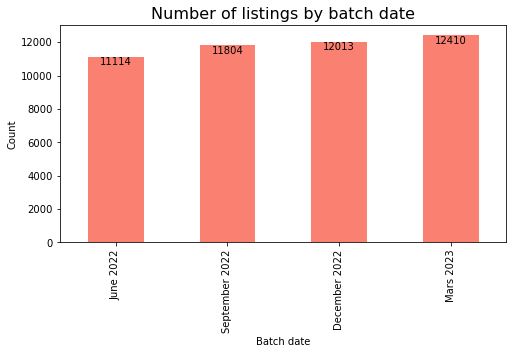

In [22]:
# create the count of listings by batch date
value_counts = full_data_df["calendar_last_scraped"].value_counts()

# change the date format to extensive for visualization purposes 
index_mapping = {"2022-06-01" : "June 2022",
                 "2022-09-01" : "September 2022",
                 "2022-12-01" : "December 2022",
                 "2023-03-01" : "Mars 2023"}

value_counts = value_counts.sort_index()
value_counts = value_counts.reset_index()
value_counts['index'] = value_counts['index'].astype(str).replace(index_mapping)
value_counts = value_counts.set_index('index')

# Plot the bar chat
ax = value_counts.plot.bar(figsize=(8,4),color="salmon",legend=False)

for i, value in enumerate(value_counts['calendar_last_scraped']):
    if not np.isnan(value):
        ax.annotate(f"""{value}""", (i, value), ha='center', va='top')
        
ax.set_title("Number of listings by batch date", fontsize=16)
ax.set_xlabel("Batch date")
ax.set_ylabel("Count")

plt.show()

__Observation__: It is possible to see a considerable increase in the number of listings considering the fact that these increases occur in just a 3-month period.

Print a table with the number of listings by batch date broken down by city

In [61]:
# create the count of listings by batch date by city
value_counts = full_data_df.groupby(["calendar_last_scraped", "neighbourhood_group_cleansed"]).size().unstack()

# change the date format to extensive for visualization purposes 
index_mapping = {"2022-06-01" : "June 2022",
                 "2022-09-01" : "September 2022",
                 "2022-12-01" : "December 2022",
                 "2023-03-01" : "Mars 2023"}

value_counts = value_counts.sort_index()
value_counts = value_counts.reset_index()
value_counts['calendar_last_scraped'] = value_counts['calendar_last_scraped'].astype(str).replace(index_mapping)
value_counts = value_counts.set_index('calendar_last_scraped')
value_counts = value_counts.T

value_counts.reset_index().sort_values("Mars 2023", ascending=False).style.hide_index()

neighbourhood_group_cleansed,June 2022,September 2022,December 2022,Mars 2023
PORTO,7960,8518,8901,9248
VILA NOVA DE GAIA,1200,1246,1285,1319
MATOSINHOS,445,468,482,500
VILA DO CONDE,277,299,289,285
PÓVOA DE VARZIM,296,294,246,256
AROUCA,151,156,136,136
GONDOMAR,112,124,119,126
ESPINHO,179,188,120,120
MAIA,92,95,89,89
VALE DE CAMBRA,65,73,60,62


__Observation__: The first thing I noticed here is again how skewed the data is. Secondly almost all of cities kept the increasing trend but some cities like Maia, Espinho, or Arouca show a decrease in the offerings. 

Let's see this in two graphics: one for the biggest cities in terms of oferigns and a second for the rest.

In [24]:
# create a separated Dataframe with the results from the table above
value_counts_by_city = value_counts.reset_index().sort_values("Mars 2023", ascending=False)
value_counts_by_city = value_counts_by_city.set_index('neighbourhood_group_cleansed')

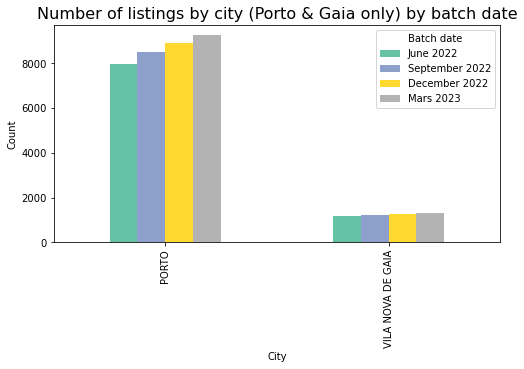

In [106]:
# Plot the 1st bar chat
ax = value_counts_by_city[value_counts_by_city.index.isin(["PORTO","VILA NOVA DE GAIA"])].plot.bar(figsize=(8,4), legend=True, cmap='Set2')

ax.set_title("Number of listings by city (Porto & Gaia only) by batch date", fontsize=16)
ax.set_xlabel("City")
ax.set_ylabel("Count")

plt.legend(title="Batch date")

plt.show()

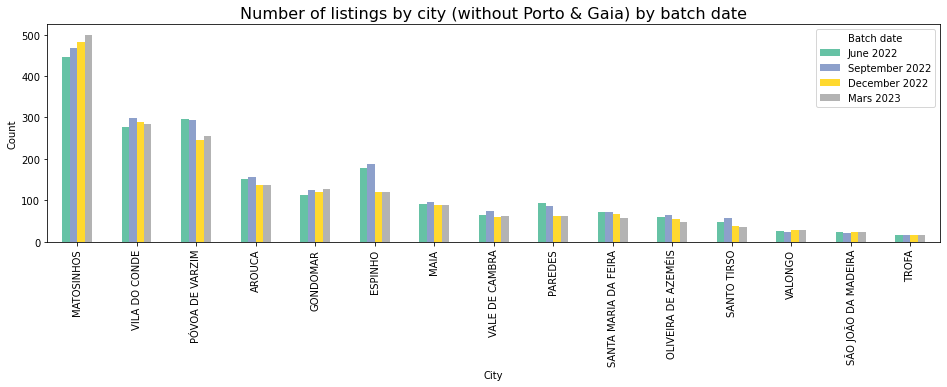

In [105]:
# Plot the 1st bar chat
ax = value_counts_by_city[~value_counts_by_city.index.isin(["PORTO","VILA NOVA DE GAIA"])].plot.bar(figsize=(16,4), legend=True, cmap='Set2')

ax.set_title("Number of listings by city (without Porto & Gaia) by batch date", fontsize=16)
ax.set_xlabel("City")
ax.set_ylabel("Count")

plt.legend(title="Batch date")

plt.show()

### Analysis of the occupancy rates

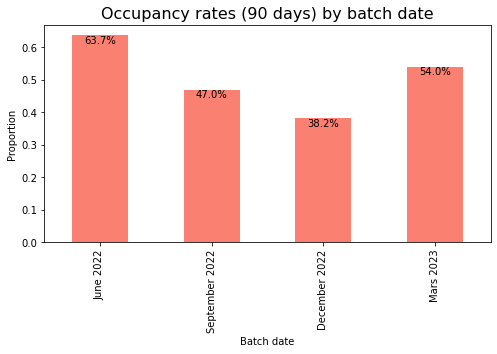

The overall mean of the 90-day occupancy rates between June 2022 and Mars 2023 was 51%.


In [99]:
### get the mean value of the occupancy rates by batch date
occ_rates_by_batch = full_data_df.groupby("calendar_last_scraped")["occupancy_rate_90"].mean()

# change the date format to extensive for visualization purposes 
index_mapping = {"2022-06-01" : "June 2022",
                 "2022-09-01" : "September 2022",
                 "2022-12-01" : "December 2022",
                 "2023-03-01" : "Mars 2023"}

occ_rates_by_batch = occ_rates_by_batch.sort_index()
occ_rates_by_batch = occ_rates_by_batch.reset_index()
occ_rates_by_batch['calendar_last_scraped'] = occ_rates_by_batch['calendar_last_scraped'].astype(str).replace(index_mapping)
occ_rates_by_batch = occ_rates_by_batch.set_index("calendar_last_scraped")

# Plot the bar chat
ax = occ_rates_by_batch.plot.bar(figsize=(8,4),color="salmon",legend=False)

for i, value in enumerate(occ_rates_by_batch['occupancy_rate_90']):
    if not np.isnan(value):
        ax.annotate(f"""{value*100:.1f}%""", (i, value), ha='center', va='top')
        
ax.set_title("Occupancy rates (90 days) by batch date", fontsize=16)
ax.set_xlabel("Batch date")
ax.set_ylabel("Proportion")

plt.show();
print("The overall mean of the 90-day occupancy rates between June 2022 and Mars 2023 was {}%.".format(round(full_data_df["occupancy_rate_90"].mean()*100),2))

__Observation__: We can see that in the colder months the occupancy rate tends to decrease, as it is expected since Porto is a touristic city, which is highly impacted by the Tourism seasons of the nothern hemisphere. Now let us see if there are noticeable differences between superhosts and non-superhosts.

In [28]:
occ_rates_by_batch_by_host = full_data_df.groupby(["calendar_last_scraped","host_is_superhost"])["occupancy_rate_90"].mean().unstack()
occ_rates_by_batch_by_host

host_is_superhost,f,t
calendar_last_scraped,,
2022-06-01,0.623985,0.671584
2022-09-01,0.471338,0.467840
2022-12-01,0.395005,0.354595
2023-03-01,0.523198,0.574575


- __Observation__: This was an interesting finding: One could assume that superhosts would have a bigger occupancy rate, since this is a special distinction in the Airbnb platform, but this data suggests that the numbers are much similar. However, it seems that as the occupancy rates increase, the difference between the two also increases in favor of the superhosts.
- __Suggestion__: One could try to explain this by looking at the price distribution of the occupied and free listings to see if price matters here or looke into the person correlation to see if this is really a trend but due to lack of historical data and the scope of this project this will be ignored.

In [69]:
#Print the mean occupancy rate by city for the 12-month period
full_data_df.groupby("neighbourhood_group_cleansed")["occupancy_rate_90"].mean().sort_values(ascending=False)

neighbourhood_group_cleansed
MATOSINHOS              0.552419
VILA NOVA DE GAIA       0.522174
MAIA                    0.514977
PORTO                   0.514593
SÃO JOÃO DA MADEIRA     0.499638
VALONGO                 0.492169
PÓVOA DE VARZIM         0.471551
ESPINHO                 0.462237
VILA DO CONDE           0.443469
GONDOMAR                0.433726
PAREDES                 0.408646
SANTA MARIA DA FEIRA    0.385779
SANTO TIRSO             0.366355
TROFA                   0.327951
OLIVEIRA DE AZEMÉIS     0.313078
VALE DE CAMBRA          0.303248
AROUCA                  0.264172
Name: occupancy_rate_90, dtype: float64

Print the 90-day occupancy rates by batch date and by city

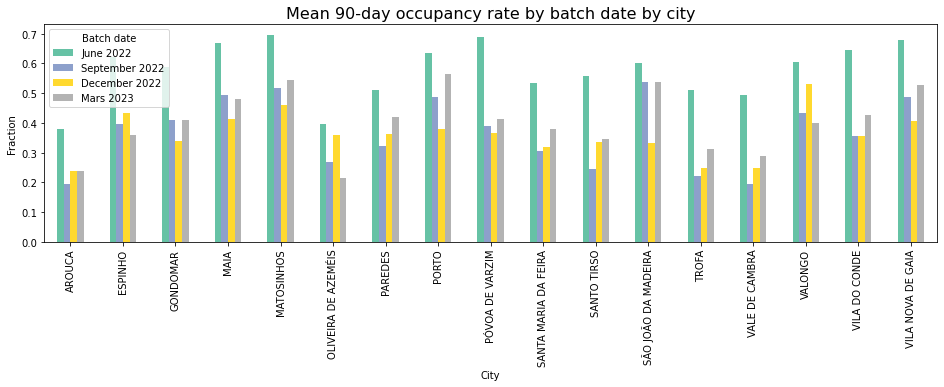

In [104]:
# get the mean value of the occupancy rates by batch date by city
occ_rates_by_batch_by_city = full_data_df.groupby(["calendar_last_scraped","neighbourhood_group_cleansed"])["occupancy_rate_90"].mean().unstack()

# change the date format to extensive for visualization purposes 
index_mapping = {"2022-06-01" : "June 2022",
                 "2022-09-01" : "September 2022",
                 "2022-12-01" : "December 2022",
                 "2023-03-01" : "Mars 2023"}

occ_rates_by_batch_by_city = occ_rates_by_batch_by_city.sort_index()
occ_rates_by_batch_by_city = occ_rates_by_batch_by_city.reset_index()
occ_rates_by_batch_by_city['calendar_last_scraped'] = occ_rates_by_batch_by_city['calendar_last_scraped'].astype(str).replace(index_mapping)
occ_rates_by_batch_by_city = occ_rates_by_batch_by_city.set_index('calendar_last_scraped')
occ_rates_by_batch_by_city = occ_rates_by_batch_by_city.T

# Plot the bar chat
ax = occ_rates_by_batch_by_city.plot.bar(figsize=(16,4), legend=True, cmap='Set2')

ax.set_title("Mean 90-day occupancy rate by batch date by city", fontsize=16)
ax.set_xlabel("City")
ax.set_ylabel("Fraction")

plt.legend(title="Batch date")

plt.show()

### Analysis of the prices

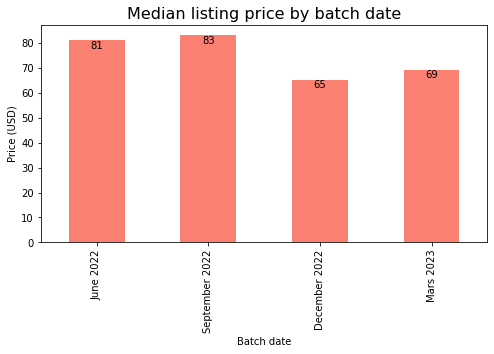

The overall median of the 90-day unit price between June 2022 and Mars 2023 was $75.0.


In [123]:
### get the mean value of the occupancy rates by batch date
prices_by_batch = full_data_df.groupby("calendar_last_scraped")["price_usd"].median()

# change the date format to extensive for visualization purposes 
index_mapping = {"2022-06-01" : "June 2022",
                 "2022-09-01" : "September 2022",
                 "2022-12-01" : "December 2022",
                 "2023-03-01" : "Mars 2023"}

prices_by_batch = prices_by_batch.sort_index()
prices_by_batch = prices_by_batch.reset_index()
prices_by_batch['calendar_last_scraped'] = prices_by_batch['calendar_last_scraped'].astype(str).replace(index_mapping)
prices_by_batch = prices_by_batch.set_index("calendar_last_scraped")

# Plot the bar chat
ax = prices_by_batch.plot.bar(figsize=(8,4),color="salmon",legend=False)

for i, value in enumerate(prices_by_batch['price_usd']):
    ax.annotate(f"""{value:.0f}""", (i, value), ha='center', va='top')
        
ax.set_title("Median listing price by batch date", fontsize=16)
ax.set_xlabel("Batch date")
ax.set_ylabel("Price (USD)")

plt.show();
print("The overall median of the 90-day unit price between June 2022 and Mars 2023 was ${}.".format(full_data_df["price_usd"].median()))

__Observations__: 
- The prices seem vary between the time of the year but without more historical data is impossible to determine if there is a trend here. 
- Price can also be related with other factors like location, number of bedrooms or if it is a superhost

In [125]:
#Print the media unit price rate by caty for the 12-month period
full_data_df.groupby("neighbourhood_group_cleansed")["price_usd"].median().sort_values(ascending=False)

neighbourhood_group_cleansed
TROFA                   120.0
VALE DE CAMBRA          110.5
GONDOMAR                100.0
AROUCA                   99.0
SANTO TIRSO              92.5
PAREDES                  92.0
VILA DO CONDE            80.0
PÓVOA DE VARZIM          80.0
ESPINHO                  75.0
PORTO                    74.0
SANTA MARIA DA FEIRA     70.0
VILA NOVA DE GAIA        70.0
VALONGO                  69.0
MATOSINHOS               68.0
MAIA                     65.0
OLIVEIRA DE AZEMÉIS      60.0
SÃO JOÃO DA MADEIRA      49.0
Name: price_usd, dtype: float64

In [181]:
### get the mean value of the occupancy rates by batch date
prices_by_bedrooms = full_data_df.groupby("bedrooms")["price_usd"].median()

# transform the nummeric value of bedrooms into categories 
ranges = [(0, 0), (1, 26), (25, 51), (50, 76), (75, 101), (100, 1000)]
labels = ['0', '1-25', '25-50', '50-75', '75-100', '+100']

#prices_by_bedrooms = prices_by_bedrooms.sort_index()
#prices_by_bedrooms = prices_by_bedrooms.reset_index()
#prices_by_bedrooms['bedrooms'] = pd.cut(prices_by_bedrooms['bedrooms'], bins=ranges, labels=labels)

In [182]:
prices_by_bedrooms

bedrooms
1.0       65.0
2.0       90.0
3.0      116.0
4.0      185.5
5.0      248.0
6.0      357.0
7.0      452.0
8.0      450.0
9.0      702.0
10.0      60.0
11.0     999.0
14.0      90.0
16.0    1875.0
Name: price_usd, dtype: float64

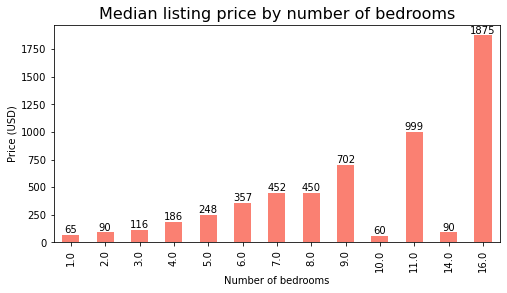

In [184]:
### get the mean value of the occupancy rates by batch date
prices_by_bedrooms = full_data_df.groupby("bedrooms")["price_usd"].median()

# Plot the bar chat
ax = prices_by_bedrooms.plot.bar(figsize=(8,4),color="salmon",legend=False)

for i, value in enumerate(prices_by_bedrooms):
    ax.annotate(f"""{value:.0f}""", (i, value), ha='center', va='bottom')
        
ax.set_title("Median listing price by number of bedrooms", fontsize=16)
ax.set_xlabel("Number of bedrooms")
ax.set_ylabel("Price (USD)")

plt.show();

__Observation:__ As expected the median value unit price tends to increase with the number of bedrooms. There are two values that do not follow this trend but this can this can just be highly influence due to the small amout of listings for these categories. Example: 

In [155]:
# Print number of units with 10 bedrooms by batch date
full_data_df[full_data_df["bedrooms"] == 10].groupby(["bedrooms", "calendar_last_scraped"]).size()

bedrooms  calendar_last_scraped
10.0      2022-06-01               5
          2022-09-01               5
          2022-12-01               4
          2023-03-01               4
dtype: int64

In [129]:
#Print the media unit price rate by city for the 12-month period
full_data_df.groupby("host_is_superhost")["price_usd"].median()

host_is_superhost
f    71.0
t    79.0
Name: price_usd, dtype: float64

__Observation__: Superhosts seem to have a slighty bigger median price per unit.

In [186]:
# get the mean value of the occupancy rates by batch date
occ_rate_by_reviews = full_data_df.groupby("number_of_reviews")["occupancy_rate_90"].mean()

# transform the nummeric value of bedrooms into categories 
ranges = [(0, 0), (1, 26), (25, 51), (50, 76), (75, 101), (100, 1000)]
labels = ['0', '1-25', '25-50', '50-75', '75-100', '+100']

occ_rate_by_reviews = occ_rate_by_reviews.sort_index()
occ_rate_by_reviews = occ_rate_by_reviews.reset_index()
occ_rate_by_reviews['number_of_reviews'] = pd.cut(occ_rate_by_reviews['number_of_reviews'], bins=ranges, labels=labels)
occ_rate_by_reviews = occ_rate_by_reviews.set_index("number_of_reviews")

# Plot the bar chat
ax = occ_rate_by_reviews.plot.bar(figsize=(8,4),color="salmon",legend=False)
        
ax.set_title("Median listing price by number of bedrooms", fontsize=16)
ax.set_xlabel("Number of bedrooms")
ax.set_ylabel("Price (USD)")

plt.show();

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [201]:
occ_rate_by_reviews['number_of_reviews']

0        0
1        1
2        2
3        3
4        4
      ... 
594    777
595    781
596    796
597    818
598    833
Name: number_of_reviews, Length: 599, dtype: int64

In [230]:
occ_rate_by_reviews = full_data_df.groupby("number_of_reviews")["occupancy_rate_90"].mean()
occ_rate_by_reviews = occ_rate_by_reviews.sort_index()
occ_rate_by_reviews = occ_rate_by_reviews.reset_index()

bins = [0, 25, 50, 75, 100, 1000]
labels = ['1-25', '26-50', '51-75', '76-100', '+100']

occ_rate_by_reviews['number_of_reviews'] = pd.cut(occ_rate_by_reviews['number_of_reviews'], bins=bins, labels=labels)
#occ_rate_by_reviews['number_of_reviews'] = occ_rate_by_reviews['number_of_reviews'].map({'NaN':"0"})

In [231]:
occ_rate_by_reviews

,number_of_reviews,occupancy_rate_90
0,NaN,0.450836
1,1-25,0.463919
2,1-25,0.444870
3,1-25,0.473536
4,1-25,0.491478
...,...,...
594,+100,0.922222
595,+100,0.977778
596,+100,0.611111
597,+100,0.277778


In [143]:
# see which other graphics could be used to show the distribution of the data (for example to see the outliers)

In [72]:
# try and print the counts, listing and occupancy rates on a map using latitude and longitude

## Status Quo 2023